In [1]:
import pandas as pd
import os
import glob

In [2]:
# Define legend categories
legend_categories = {
    'Assault': ['Bangalore', 'Fuse', 'Ash', 'Mad Maggie', 'Ballistic'],
    'Skirmisher': ['Pathfinder', 'Wraith', 'Octane', 'Revenant', 'Horizon', 'Valkyrie','Alter'],
    'Recon': ['Bloodhound', 'Crypto', 'Seer', 'Vantage'],
    'Support': ['Gibraltar', 'Lifeline', 'Mirage', 'Loba', 'Newcastle', 'Conduit'],
    'Controller': ['Caustic', 'Wattson', 'Rampart', 'Catalyst']
}

In [3]:
# Flatten the dictionary to map legend to category
legend_to_category = {}
for category, legends in legend_categories.items():
    for legend in legends:
        legend_to_category[legend] = category

In [ ]:
# Load your CSV files
# Assuming the CSV files are in a directory named 'data'
base_path = ""

damage_path = os.path.join(base_path, 'Legend Damage')
kills_path = os.path.join(base_path, 'Legend Kills')
matches_path = os.path.join(base_path, 'Legend Matches Played')
wins_path = os.path.join(base_path, 'Legend Wins')
# Function to list files in a directory
def list_files(directory):
    print(f"Files in {directory}:")
    for f in os.listdir(directory):
        print(f)

In [5]:
# Initialize an empty list to hold dataframes for each legend
legend_dataframes = []

# Get list of legends
legends = list(legend_to_category.keys())

In [6]:
#Loop over each legend
for legend in legends:
    try:
        # Build file paths for the legend
        legend_damage_file = os.path.join(damage_path, f"{legend}_damage.csv")
        legend_kills_file = os.path.join(kills_path, f"{legend}_kills.csv")
        legend_matches_file = os.path.join(matches_path, f"{legend}_games_played.csv")  # Updated suffix
        legend_wins_file = os.path.join(wins_path, f"{legend}_wins.csv")
        
        # Check if all files exist
        required_files = [legend_damage_file, legend_kills_file, legend_matches_file, legend_wins_file]
        missing_files = [f for f in required_files if not os.path.exists(f)]
        if missing_files:
            print(f"Data files for legend '{legend}' are missing: {missing_files}. Skipping this legend.")
            continue  # Skip to the next legend if any file is missing
        
        # Read the data files
        df_damage = pd.read_csv(legend_damage_file, header=None, names=['Damage'], skiprows=1)
        df_matches = pd.read_csv(legend_matches_file, header=None, names=['Games Played'], skiprows=1)
        df_wins = pd.read_csv(legend_wins_file, header=None, names=['Wins'], skiprows=1)

        # Custom converter to handle numeric values and ignore non-numeric ones
        def convert_number(s):
            try:
                # Remove commas and quotes, then convert to integer
                return int(str(s).replace(',', '').replace('"', '').strip())
            except ValueError:
                # Return NaN if conversion fails
                return pd.NA

        # Read the kills CSV file with the custom converter
        df_kills = pd.read_csv(legend_kills_file, header=None, names=['Kills'], converters={0: convert_number}, skiprows=1)

        # Combine the data into a single DataFrame, aligning on index (axis=1)
        df_legend = pd.concat([df_damage.reset_index(drop=True), 
                               df_kills.reset_index(drop=True), 
                               df_matches.reset_index(drop=True), 
                               df_wins.reset_index(drop=True)], axis=1)

        # Add 'legend_name' column to identify the legend in the combined DataFrame
        df_legend['legend_name'] = legend

        # Append the processed DataFrame to the list
        legend_dataframes.append(df_legend)
    
    except Exception as e:
        # Catch any exceptions during processing and print the error
        print(f"An error occurred while processing legend '{legend}': {e}")

In [7]:
# Concatenate all legend dataframes
all_legends_df = pd.concat(legend_dataframes, ignore_index=True)
# Map legends to categories
all_legends_df['Legend_Category'] = all_legends_df['legend_name'].map(legend_to_category)
# # List of legends with missing Wins data
legends_missing_wins = ['Ballistic', 'Conduit', 'Alter', 'Newcastle']
# Filter out legends with missing Wins data
all_legends_df = all_legends_df[~all_legends_df['legend_name'].isin(legends_missing_wins)]
print(all_legends_df)

           Damage   Kills  Games Played   Wins legend_name Legend_Category
0      1335473024  192425         47418  15355   Bangalore         Assault
1        50500034  177520         35645  14088   Bangalore         Assault
2        48186631  172382         32770  13041   Bangalore         Assault
3        45909908  170902         30597  12675   Bangalore         Assault
4        45231990  168326         28659  12637   Bangalore         Assault
...           ...     ...           ...    ...         ...             ...
12995     1752140    6767           997    151    Catalyst      Controller
12996     1751077    6740           994    150    Catalyst      Controller
12997     1750218    6740           990    150    Catalyst      Controller
12998     1749964    6737           990    150    Catalyst      Controller
12999     1749508    6718           988    150    Catalyst      Controller

[11000 rows x 6 columns]


In [8]:
# Ensure that columns are numeric, forcing invalid values to NaN
all_legends_df['Kills'] = pd.to_numeric(all_legends_df['Kills'], errors='coerce')
all_legends_df['Wins'] = pd.to_numeric(all_legends_df['Wins'], errors='coerce')
all_legends_df['Games Played'] = pd.to_numeric(all_legends_df['Games Played'], errors='coerce')
all_legends_df['Damage'] = pd.to_numeric(all_legends_df['Damage'], errors='coerce')

# Avoid division by zero and handle NaN
all_legends_df['Kills_per_Win'] = all_legends_df.apply(lambda row: row['Kills'] / row['Wins'] if pd.notna(row['Wins']) and row['Wins'] > 0 else 0, axis=1)
all_legends_df['Kills_per_Match'] = all_legends_df.apply(lambda row: row['Kills'] / row['Games Played'] if pd.notna(row['Games Played']) and row['Games Played'] > 0 else 0, axis=1)
all_legends_df['Damage_per_Match'] = all_legends_df.apply(lambda row: row['Damage'] / row['Games Played'] if pd.notna(row['Games Played']) and row['Games Played'] > 0 else 0, axis=1)

# Group by 'Legend_Category' and calculate the mean of the relevant columns
averaged_stats_df = all_legends_df.groupby('Legend_Category').agg(
    Average_Kills_per_Win=('Kills_per_Win', 'mean'),
    Average_Kills_per_Match=('Kills_per_Match', 'mean'),
    Average_Damage_per_Match=('Damage_per_Match', 'mean')
).reset_index()

# Display the aggregated statistics
print(averaged_stats_df)

  Legend_Category  Average_Kills_per_Win  Average_Kills_per_Match  \
0         Assault              20.182228                 5.317327   
1      Controller              24.195288                 5.117616   
2           Recon              19.728249                 4.704346   
3      Skirmisher              18.516093                 5.040864   
4         Support              16.389824                 4.985961   

   Average_Damage_per_Match  
0               1591.832099  
1               1467.854745  
2               1444.803915  
3               1349.504830  
4               1400.111576  


In [9]:
# List of legends with missing Wins data
legends_missing_wins = ['Ballistic', 'Conduit', 'Alter', 'Newcastle']

# Filter out these legends from the main DataFrame
filtered_legends_df = all_legends_df[~all_legends_df['legend_name'].isin(legends_missing_wins)]

# Verify the exclusion
print(filtered_legends_df['legend_name'].unique())


['Bangalore' 'Fuse' 'Ash' 'Mad Maggie' 'Pathfinder' 'Wraith' 'Octane'
 'Revenant' 'Horizon' 'Valkyrie' 'Bloodhound' 'Crypto' 'Seer' 'Vantage'
 'Gibraltar' 'Lifeline' 'Mirage' 'Loba' 'Caustic' 'Wattson' 'Rampart'
 'Catalyst']


In [10]:
filtered_legends_df

,Damage,Kills,Games Played,Wins,legend_name,Legend_Category,Kills_per_Win,Kills_per_Match,Damage_per_Match
0,1335473024,192425,47418,15355,Bangalore,Assault,12.531749,4.058058,28163.841242
1,50500034,177520,35645,14088,Bangalore,Assault,12.600795,4.980222,1416.749446
2,48186631,172382,32770,13041,Bangalore,Assault,13.218465,5.260360,1470.449527
3,45909908,170902,30597,12675,Bangalore,Assault,13.483393,5.585580,1500.470896
4,45231990,168326,28659,12637,Bangalore,Assault,13.320092,5.873408,1578.282215
...,...,...,...,...,...,...,...,...,...
12995,1752140,6767,997,151,Catalyst,Controller,44.814570,6.787362,1757.412237
12996,1751077,6740,994,150,Catalyst,Controller,44.933333,6.780684,1761.646881
12997,1750218,6740,990,150,Catalyst,Controller,44.933333,6.808081,1767.896970
12998,1749964,6737,990,150,Catalyst,Controller,44.913333,6.805051,1767.640404


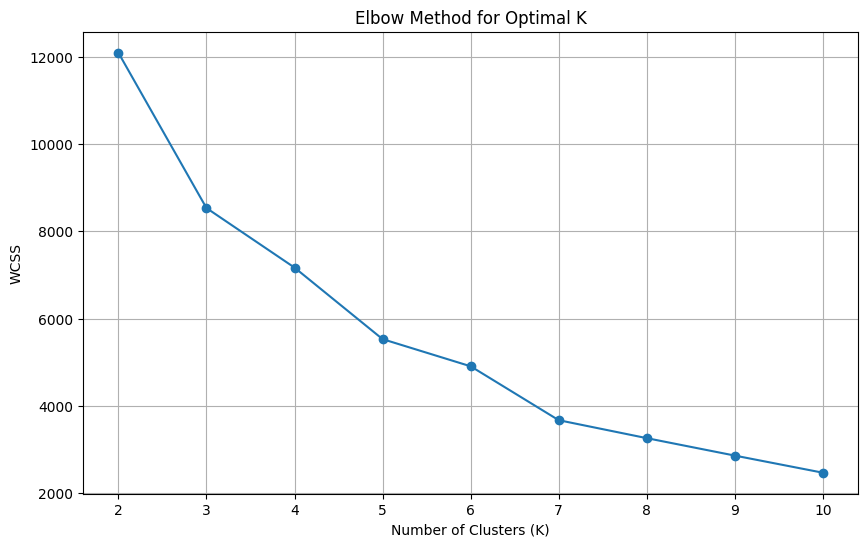

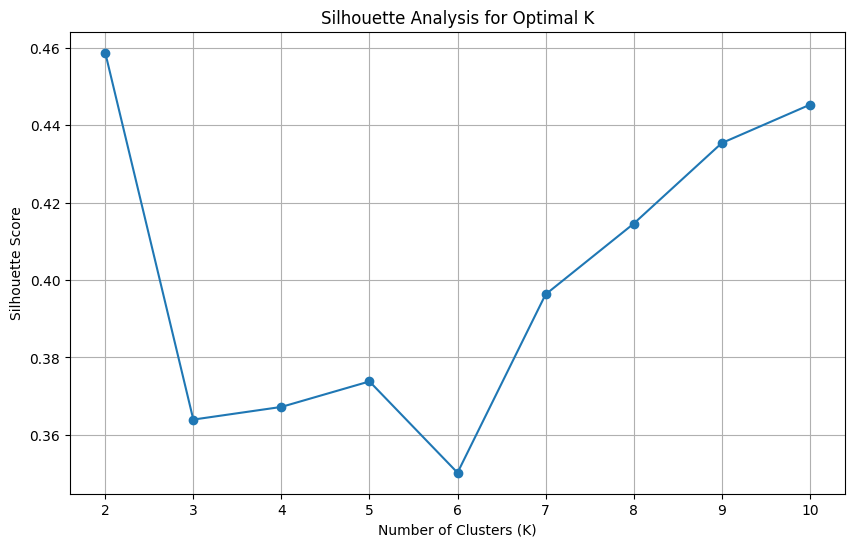

K-Means Clustering - Silhouette Score: 0.36395164373714955
K-Means Clustering - Calinski-Harabasz Index: 7956.825295862331
K-Means Clustering - Adjusted Rand Index: 0.06540095320922168
GMM Clustering - Silhouette Score: 0.2693991086084061
GMM Clustering - Calinski-Harabasz Index: 4753.727671315883
GMM Clustering - Adjusted Rand Index: 0.03964901172388192
Hierarchical Clustering - Silhouette Score: 0.3396354694581966
Hierarchical Clustering - Calinski-Harabasz Index: 7071.139644618176
Hierarchical Clustering - Adjusted Rand Index: 0.09182261327622009


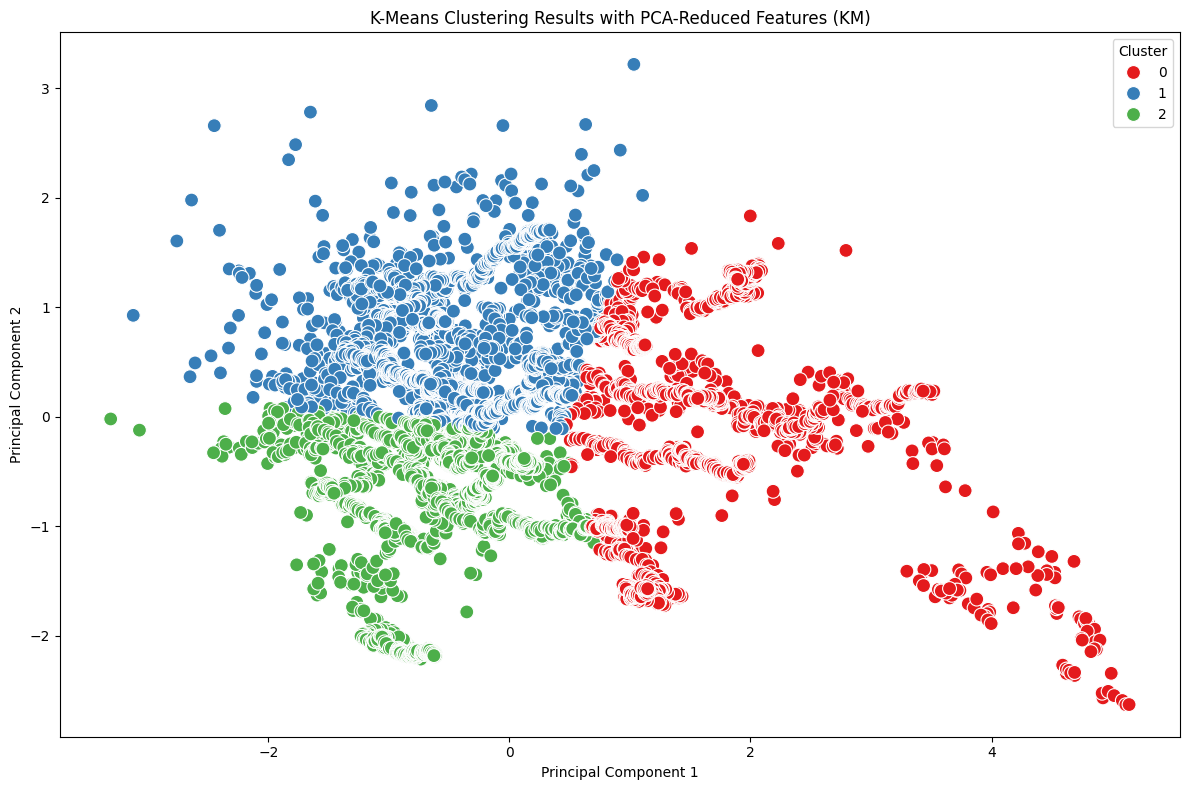

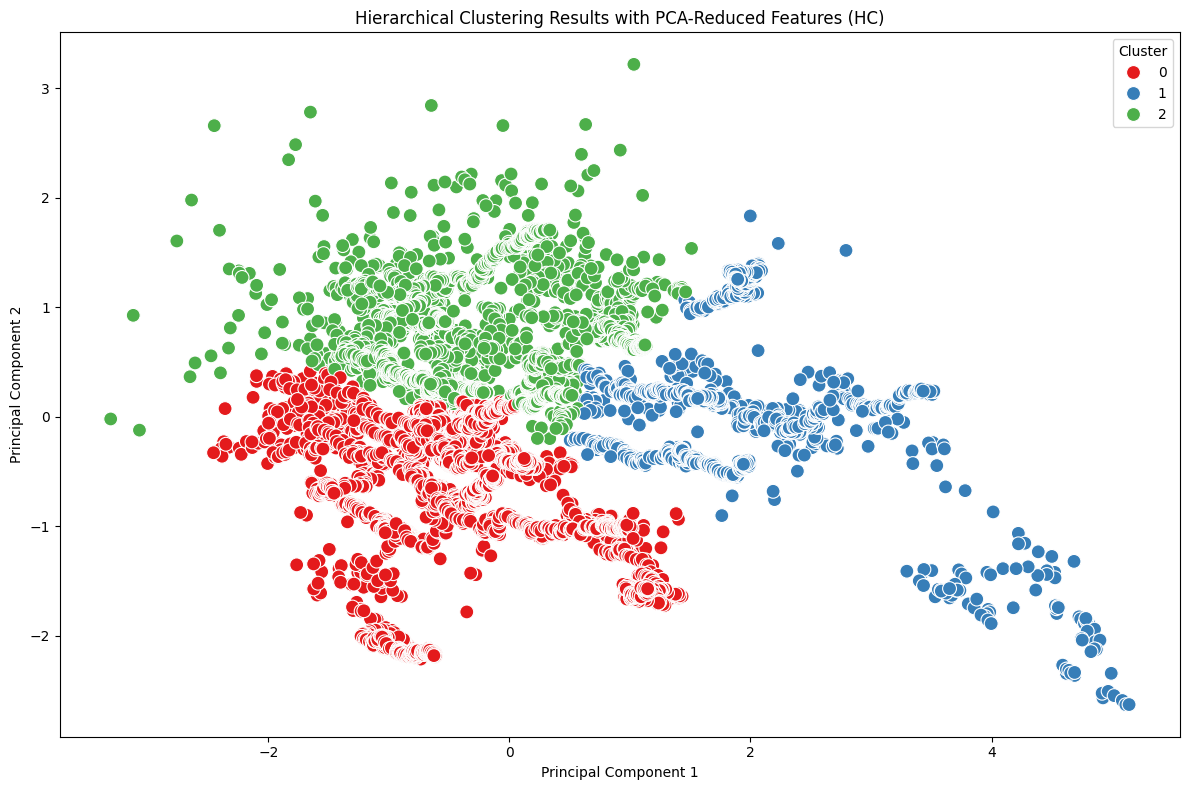

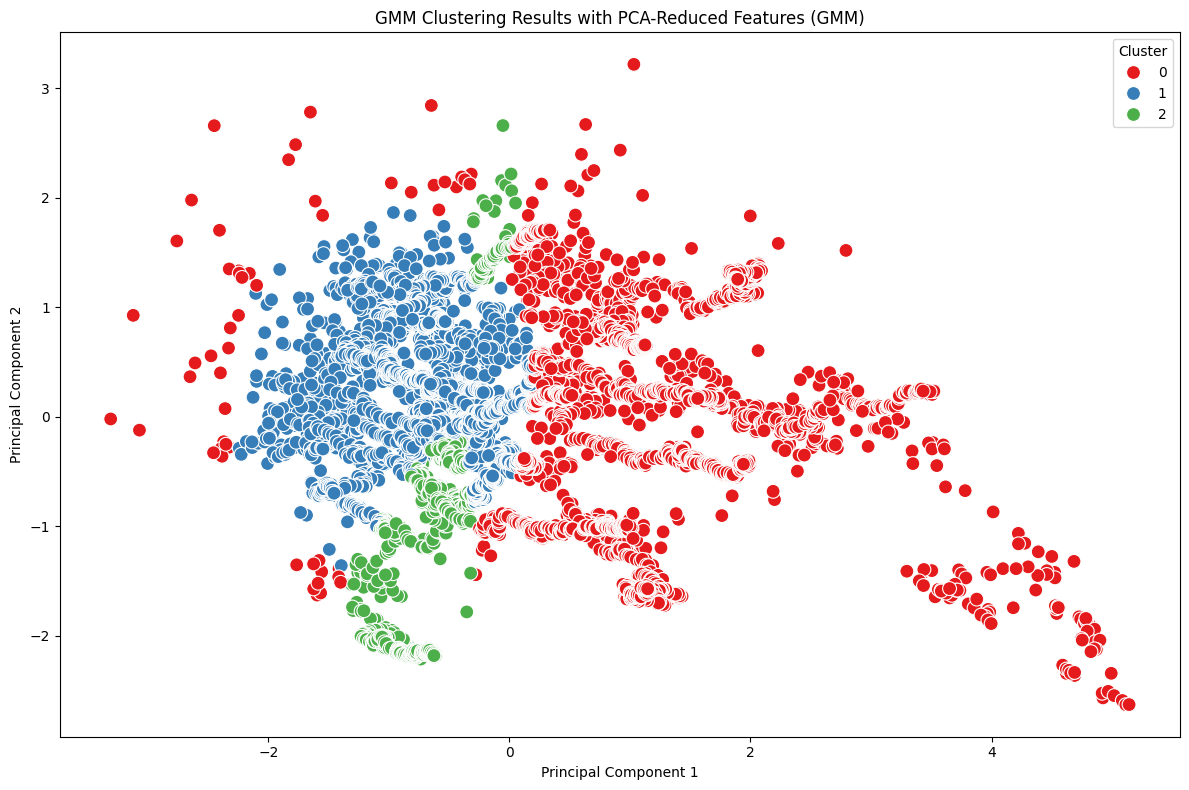

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy import stats

# 1. Data Cleaning
# Exclude incomplete data and remove outliers based only on selected metrics
filtered_legends_df = filtered_legends_df.dropna(subset=['Kills_per_Match', 'Kills_per_Win'])

# Handle Outliers using Z-score (for only Kills_per_Match and Kills_per_Win)
z_scores = np.abs(stats.zscore(filtered_legends_df[['Kills_per_Match', 'Kills_per_Win']]))
filtered_legends_df = filtered_legends_df[(z_scores < 3).all(axis=1)]

# 2. Feature Selection and Scaling
# Only include Kills_per_Match and Kills_per_Win for clustering
features = filtered_legends_df[['Kills_per_Match', 'Kills_per_Win']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. PCA for Visualization
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Legend_Category'] = filtered_legends_df['Legend_Category']

# 4. Determine Optimal K using Elbow and Silhouette
wcss = []
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Choose K=3 based on previous analysis
optimal_k = 3

# 5. Implement K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels_km = kmeans.fit_predict(scaled_features)
filtered_legends_df['Cluster_KM'] = cluster_labels_km

# 6. Implement Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
cluster_labels_gmm = gmm.fit_predict(scaled_features)
filtered_legends_df['Cluster_GMM'] = cluster_labels_gmm

# 7. Implement Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
cluster_labels_hc = hc.fit_predict(scaled_features)
filtered_legends_df['Cluster_HC'] = cluster_labels_hc

# 8. Evaluate Clustering Results

# K-Means Evaluation
silhouette_km = silhouette_score(scaled_features, cluster_labels_km)
ch_km = calinski_harabasz_score(scaled_features, cluster_labels_km)
ari_km = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_km)

print(f'K-Means Clustering - Silhouette Score: {silhouette_km}')
print(f'K-Means Clustering - Calinski-Harabasz Index: {ch_km}')
print(f'K-Means Clustering - Adjusted Rand Index: {ari_km}')

# GMM Evaluation
silhouette_gmm = silhouette_score(scaled_features, cluster_labels_gmm)
ch_gmm = calinski_harabasz_score(scaled_features, cluster_labels_gmm)
ari_gmm = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_gmm)

print(f'GMM Clustering - Silhouette Score: {silhouette_gmm}')
print(f'GMM Clustering - Calinski-Harabasz Index: {ch_gmm}')
print(f'GMM Clustering - Adjusted Rand Index: {ari_gmm}')

# Hierarchical Clustering Evaluation
silhouette_hc = silhouette_score(scaled_features, cluster_labels_hc)
ch_hc = calinski_harabasz_score(scaled_features, cluster_labels_hc)
ari_hc = adjusted_rand_score(filtered_legends_df['Legend_Category'], cluster_labels_hc)

print(f'Hierarchical Clustering - Silhouette Score: {silhouette_hc}')
print(f'Hierarchical Clustering - Calinski-Harabasz Index: {ch_hc}')
print(f'Hierarchical Clustering - Adjusted Rand Index: {ari_hc}')

# 9. Visualize Clustering Results (K-Means as Example)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_km, palette='Set1', s=100)
plt.title('K-Means Clustering Results with PCA-Reduced Features (KM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Visualize Clustering Results (Hierarchical Clustering)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_hc, palette='Set1', s=100)
plt.title('Hierarchical Clustering Results with PCA-Reduced Features (HC)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Visualize Clustering Results (GMM)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1], hue=cluster_labels_gmm, palette='Set1', s=100)
plt.title('GMM Clustering Results with PCA-Reduced Features (GMM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()



In [12]:
#K means clustering
cluster_profiles_km = filtered_legends_df.groupby('Cluster_KM').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_km")
print(cluster_profiles_km)
#HC clustering
cluster_profiles_hc = filtered_legends_df.groupby('Cluster_HC').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_hc")
print(cluster_profiles_hc)
#GMM clustering
cluster_profiles_gmm = filtered_legends_df.groupby('Cluster_GMM').agg(
    Mean_Kills_per_Match=('Kills_per_Match', 'mean'),
    Mean_Kills_per_Win=('Kills_per_Win', 'mean'),
).reset_index()
print("cluster_profiles_gmm")
print(cluster_profiles_gmm)

cluster_profiles_km
   Cluster_KM  Mean_Kills_per_Match  Mean_Kills_per_Win
0           0              5.902749           22.358401
1           1              5.064068           16.716881
2           2              4.147571           19.174833
cluster_profiles_hc
   Cluster_HC  Mean_Kills_per_Match  Mean_Kills_per_Win
0           0              4.280662           19.516902
1           1              6.236859           22.805835
2           2              5.221471           16.896800
cluster_profiles_gmm
   Cluster_GMM  Mean_Kills_per_Match  Mean_Kills_per_Win
0            0              5.700308           21.223620
1            1              4.733292           16.955049
2            2              4.055910           19.350000



K-Means Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_KM                                                             
0                    851         274    666         840        1   2632
1                    652         471    445        1370     1574   4512
2                    496         905    888         787      425   3501
All                 1999        1650   1999        2997     2000  10645

K-Means Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_KM                                                      
0                  32.33       10.41  25.30       31.91     0.04
1                  14.45       10.44   9.86       30.36    34.88
2                  14.17       25.85  25.36       22.48    12.14


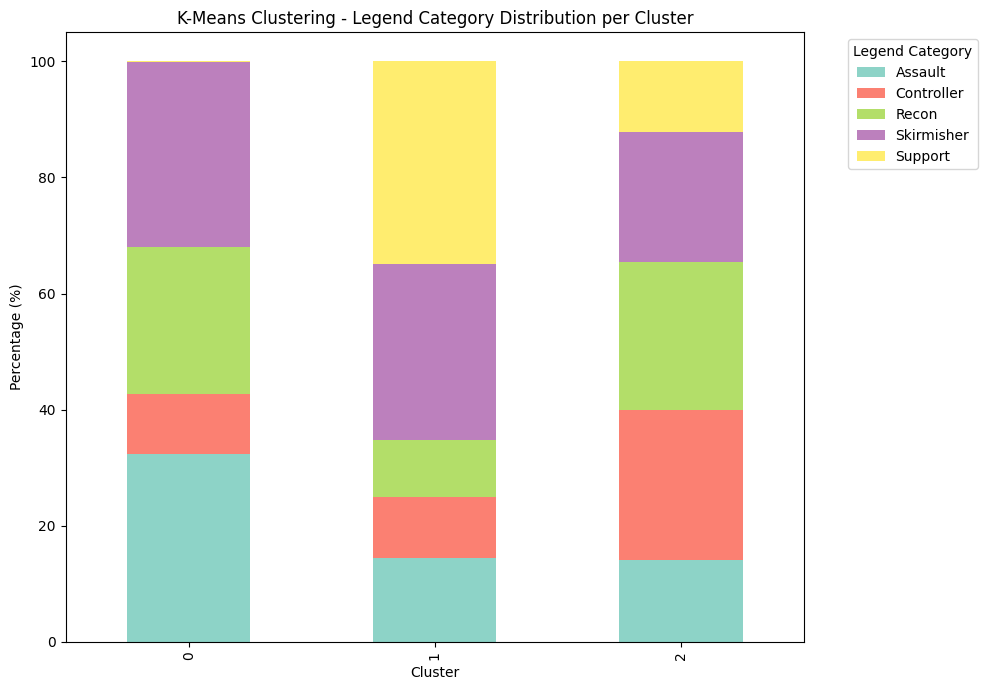


GMM Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_GMM                                                            
0                   1005         650    931         993      301   3880
1                    521         688    710        1524     1503   4946
2                    473         312    358         480      196   1819
All                 1999        1650   1999        2997     2000  10645

GMM Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_GMM                                                     
0                  25.90       16.75  23.99       25.59     7.76
1                  10.53       13.91  14.36       30.81    30.39
2                  26.00       17.15  19.68       26.39    10.78


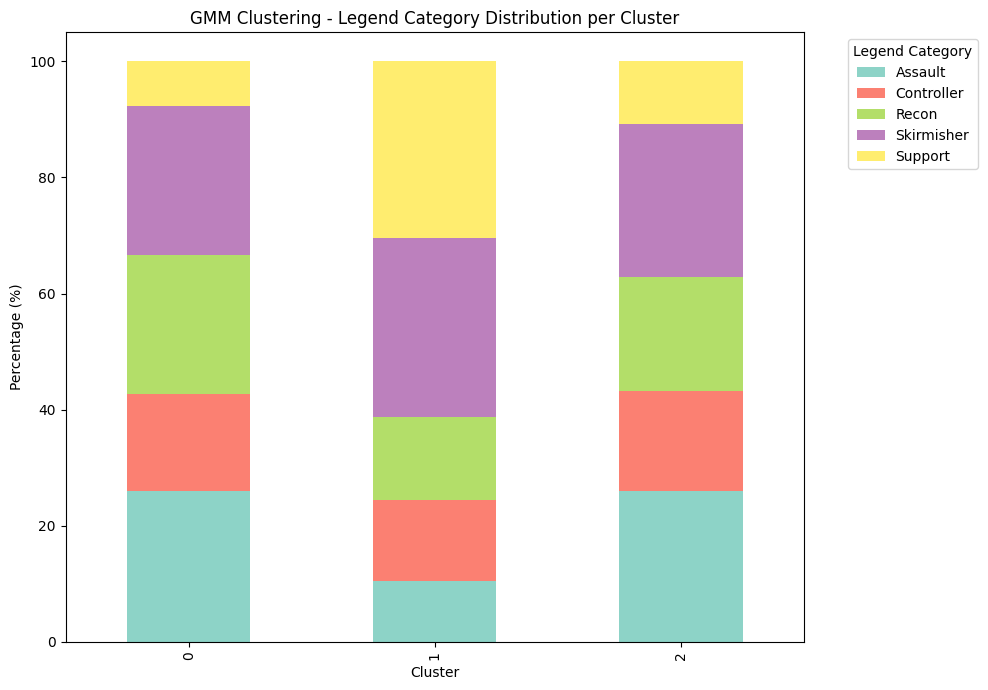


Hierarchical Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_HC                                                             
0                    504        1229   1374        1002      476   4585
1                    799         144    269         400        0   1612
2                    696         277    356        1595     1524   4448
All                 1999        1650   1999        2997     2000  10645

Hierarchical Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_HC                                                      
0                  10.99       26.80  29.97       21.85    10.38
1                  49.57        8.93  16.69       24.81     0.00
2                  15.65        6.23   8.00       35.86    34.26


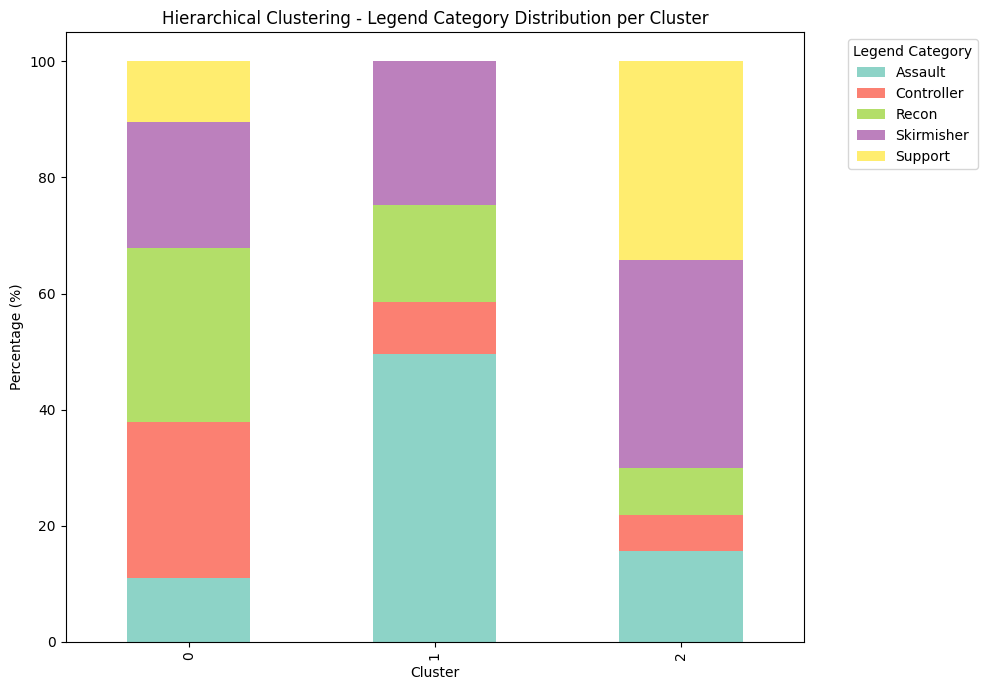

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cluster_composition_analysis(df, cluster_label, legend_label, method_name):
    """
    Generates cross-tabulation, percentage distribution, and visualization for cluster composition.
    
    Parameters:
    - df: pandas DataFrame containing cluster labels and legend categories.
    - cluster_label: string, column name for cluster labels.
    - legend_label: string, column name for legend categories.
    - method_name: string, name of the clustering method for titles.
    """
    # Cross-tabulation
    crosstab = pd.crosstab(df[cluster_label], df[legend_label], margins=True)
    print(f"\n{method_name} - Cluster Composition:")
    print(crosstab)
    
    # Percentage distribution
    crosstab_percent = pd.crosstab(df[cluster_label], df[legend_label], normalize='index') * 100
    print(f"\n{method_name} - Cluster Composition (%):")
    print(crosstab_percent.round(2))
    
    # Visualization
    crosstab_percent.plot(kind='bar', stacked=True, figsize=(10,7), colormap='Set3')
    plt.title(f'{method_name} - Legend Category Distribution per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Legend Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming 'filtered_legends_df' is your DataFrame

# K-Means Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_KM',
    legend_label='Legend_Category',
    method_name='K-Means Clustering'
)

# GMM Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_GMM',
    legend_label='Legend_Category',
    method_name='GMM Clustering'
)

# Hierarchical Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_HC',
    legend_label='Legend_Category',
    method_name='Hierarchical Clustering'
)



K-Means Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_KM                                                             
0                    851         274    666         840        1   2632
1                    652         471    445        1370     1574   4512
2                    496         905    888         787      425   3501
All                 1999        1650   1999        2997     2000  10645

K-Means Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_KM                                                      
0                  32.33       10.41  25.30       31.91     0.04
1                  14.45       10.44   9.86       30.36    34.88
2                  14.17       25.85  25.36       22.48    12.14


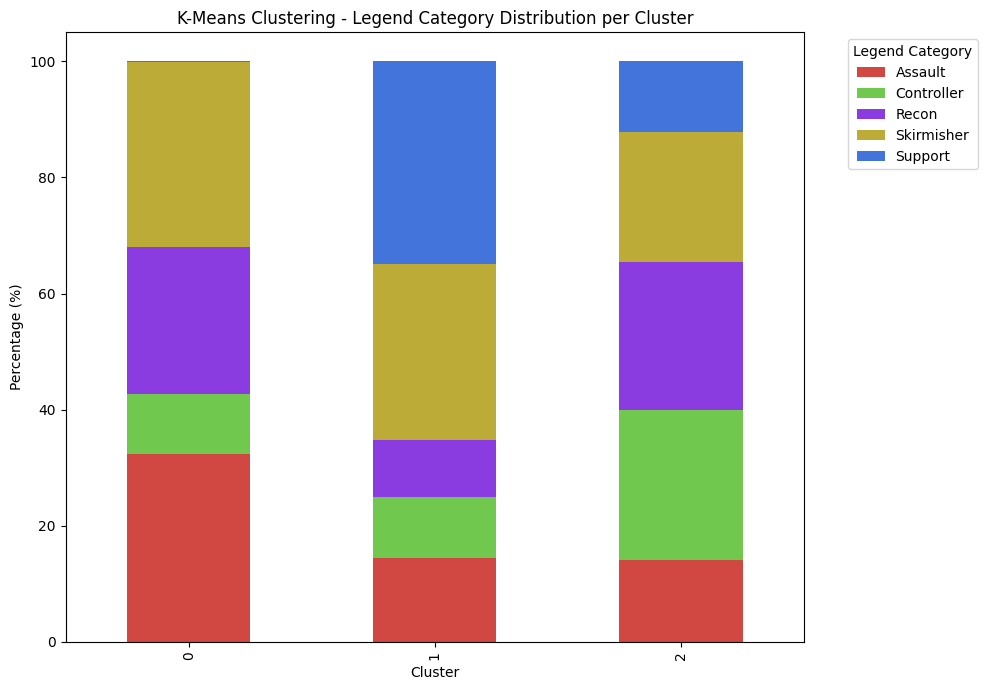


GMM Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_GMM                                                            
0                   1005         650    931         993      301   3880
1                    521         688    710        1524     1503   4946
2                    473         312    358         480      196   1819
All                 1999        1650   1999        2997     2000  10645

GMM Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_GMM                                                     
0                  25.90       16.75  23.99       25.59     7.76
1                  10.53       13.91  14.36       30.81    30.39
2                  26.00       17.15  19.68       26.39    10.78


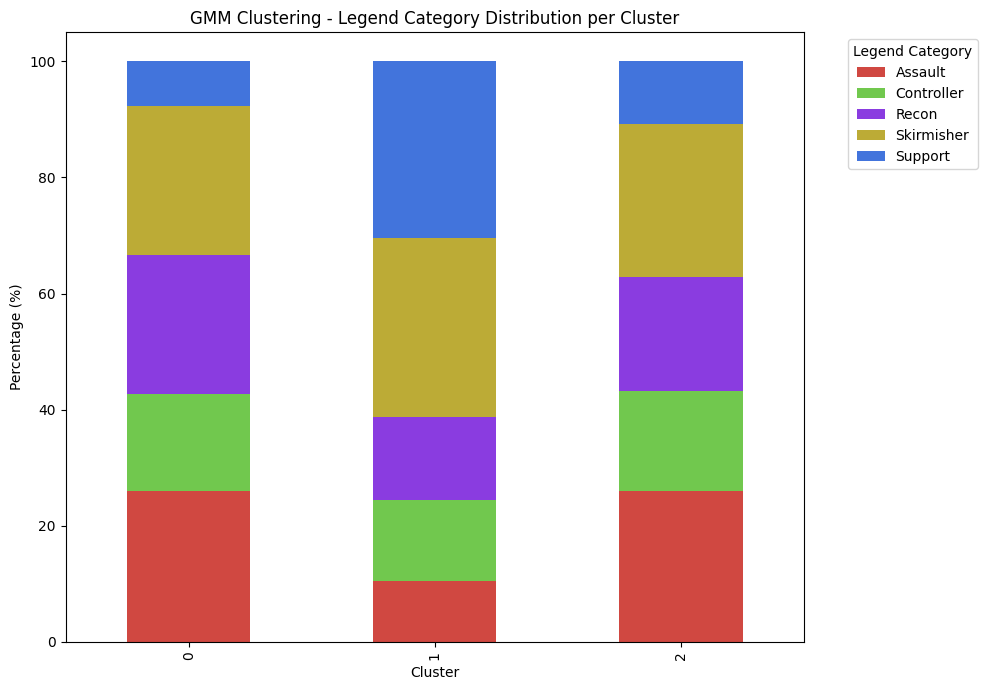


Hierarchical Clustering - Cluster Composition:
Legend_Category  Assault  Controller  Recon  Skirmisher  Support    All
Cluster_HC                                                             
0                    504        1229   1374        1002      476   4585
1                    799         144    269         400        0   1612
2                    696         277    356        1595     1524   4448
All                 1999        1650   1999        2997     2000  10645

Hierarchical Clustering - Cluster Composition (%):
Legend_Category  Assault  Controller  Recon  Skirmisher  Support
Cluster_HC                                                      
0                  10.99       26.80  29.97       21.85    10.38
1                  49.57        8.93  16.69       24.81     0.00
2                  15.65        6.23   8.00       35.86    34.26


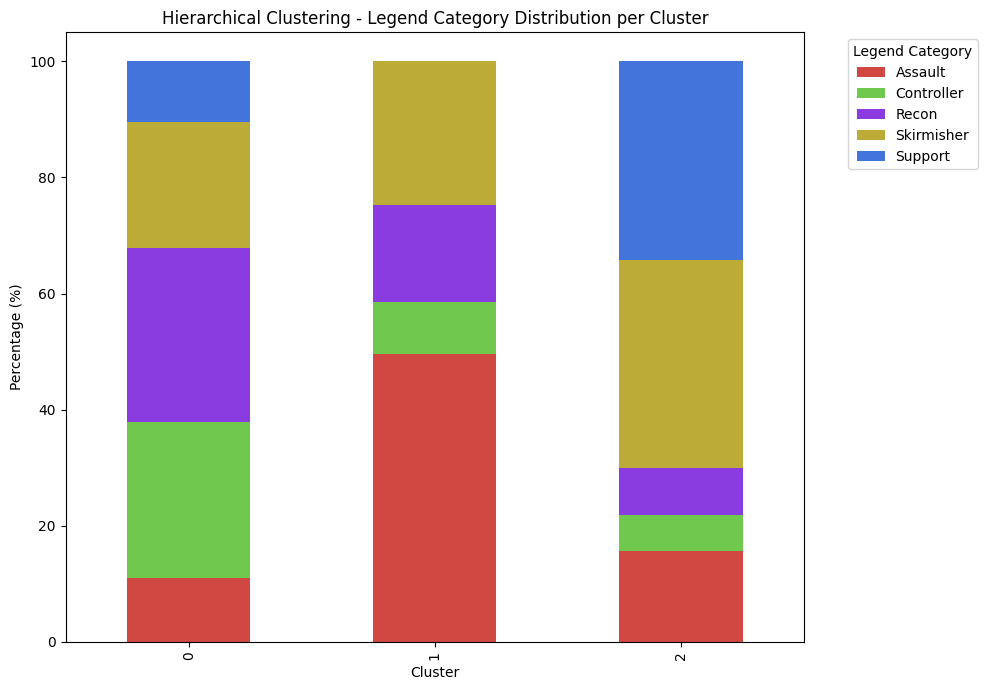

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for the categories using specified RGB values
category_colors = {
    'Assault': '#D04841',       # rgb(208,72,65)
    'Skirmisher': '#BCAB36',    # rgb(188,171,54)
    'Recon': '#8A3CE0',         # rgb(138,60,224)
    'Controller': '#71C84E',    # rgb(113,200,78)
    'Support': '#4274DC'        # rgb(66,116,220)
}

def cluster_composition_analysis(df, cluster_label, legend_label, method_name):
    """
    Generates cross-tabulation, percentage distribution, and visualization for cluster composition.
    
    Parameters:
    - df: pandas DataFrame containing cluster labels and legend categories.
    - cluster_label: string, column name for cluster labels.
    - legend_label: string, column name for legend categories.
    - method_name: string, name of the clustering method for titles.
    """
    # Cross-tabulation
    crosstab = pd.crosstab(df[cluster_label], df[legend_label], margins=True)
    print(f"\n{method_name} - Cluster Composition:")
    print(crosstab)
    
    # Percentage distribution
    crosstab_percent = pd.crosstab(df[cluster_label], df[legend_label], normalize='index') * 100
    print(f"\n{method_name} - Cluster Composition (%):")
    print(crosstab_percent.round(2))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Assign colors based on legend categories
    color_list = [category_colors.get(cat, 'grey') for cat in crosstab_percent.columns]
    
    crosstab_percent.plot(
        kind='bar',
        stacked=True,
        color=color_list,
        ax=ax
    )
    
    plt.title(f'{method_name} - Legend Category Distribution per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Legend Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming 'filtered_legends_df' is your DataFrame

# K-Means Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_KM',
    legend_label='Legend_Category',
    method_name='K-Means Clustering'
)

# GMM Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_GMM',
    legend_label='Legend_Category',
    method_name='GMM Clustering'
)

# Hierarchical Clustering
cluster_composition_analysis(
    df=filtered_legends_df,
    cluster_label='Cluster_HC',
    legend_label='Legend_Category',
    method_name='Hierarchical Clustering'
)


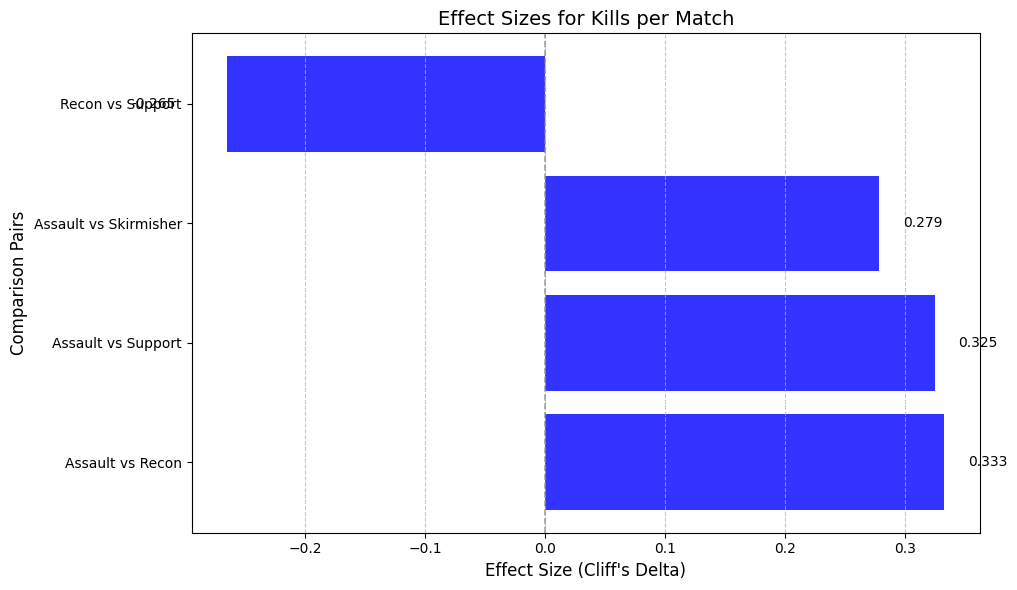

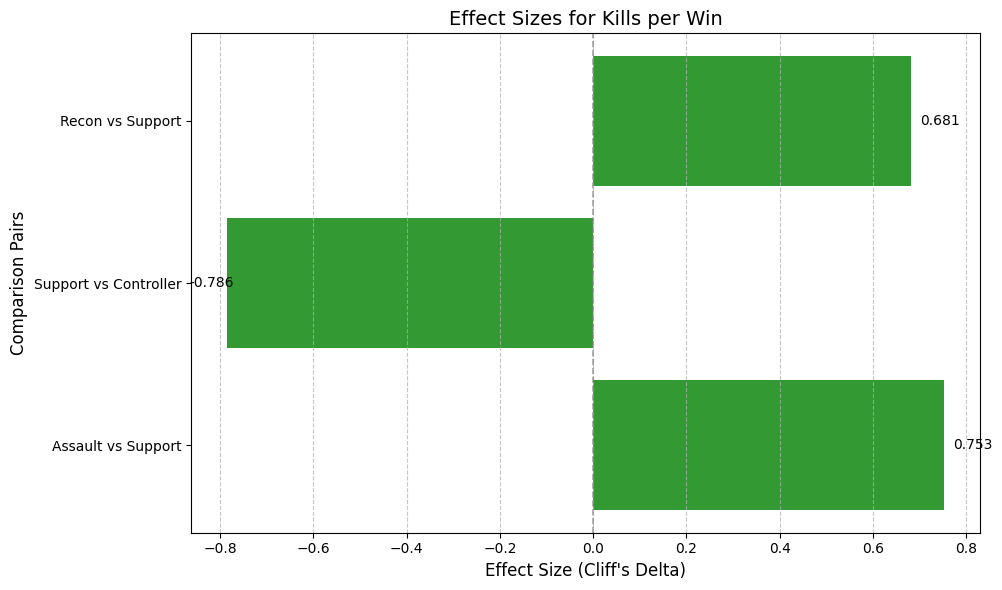

In [21]:
# Data for the horizontal bar chart - Kills per Match
pairs_kills_per_match = [
    "Assault vs Recon",
    "Assault vs Support",
    "Assault vs Skirmisher",
    "Recon vs Support"
]
effect_sizes_kills_per_match = [0.333, 0.325, 0.279, -0.265]

# Data for the horizontal bar chart - Kills per Win
pairs_kills_per_win = [
    "Assault vs Support",
    "Support vs Controller",
    "Recon vs Support"
]
effect_sizes_kills_per_win = [0.753, -0.786, 0.681]

# Create the horizontal bar chart for Kills per Match
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs_kills_per_match, effect_sizes_kills_per_match, color='blue', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)  # Reference line at 0
plt.xlabel("Effect Size (Cliff's Delta)", fontsize=12)
plt.ylabel("Comparison Pairs", fontsize=12)
plt.title("Effect Sizes for Kills per Match", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02 if width > 0 else width - 0.08,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",
             va='center',
             fontsize=10)

plt.show()

# Create the horizontal bar chart for Kills per Win
plt.figure(figsize=(10, 6))
bars = plt.barh(pairs_kills_per_win, effect_sizes_kills_per_win, color='green', alpha=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)  # Reference line at 0
plt.xlabel("Effect Size (Cliff's Delta)", fontsize=12)
plt.ylabel("Comparison Pairs", fontsize=12)
plt.title("Effect Sizes for Kills per Win", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02 if width > 0 else width - 0.08,
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",
             va='center',
             fontsize=10)

plt.show()
